# REQUIREMENTS

- Throughout the whole tutorial, we will be using the `transformers` library.
- For the fine-tuning either `pytorch` or `tensorflow` are required. (This Notebook will be implemented with `pytorch`)
- To push the fine-tuned model to HuggingFace, the `HuggingFace_hub`library is required.
- Additional libraries like `datasets`, `evaluate`, `pandas`and `numpy`will be used.

- Model and Tokenizer: The notebook uses BertForSequenceClassification and BertTokenizer from the Hugging Face Transformers library, which are specific to PyTorch.
-Functionality: The notebook includes functions to tokenize input, perform predictions using a BERT model, and save/load models using PyTorch-specific commands.


| Feature             | TensorFlow                                   | PyTorch                                      |
|---------------------|----------------------------------------------|---------------------------------------------|
| **Developer**       | Google Brain                                 | Facebook's AI Research lab                  |
| **Graph Type**      | Static (initially), Dynamic (since v2.0)     | Dynamic                                     |
| **Execution Style** | Eager execution by default in TensorFlow 2.0 | Imperative programming style                |
| **Deployment**      | TensorFlow Serving, TensorFlow Lite, TensorFlow.js | TorchScript for optimization and easier deployment |
| **Tooling**         | TensorBoard for visualization                | Rich ecosystem (TorchVision, TorchText, etc.) |
| **Integration**     | Tightly integrated with Google Cloud         | Extensive libraries for different tasks     |
| **User Interface**  | Keras integrated as high-level API           | Pythonic, more intuitive for developers     |
| **Community Use**   | Preferred in industry for production         | Highly favored in academia and research     |

Both frameworks provide similar levels of performance in terms of speed and scalability, and both can run on multiple CPUs and GPUs. The choice between them often comes down to personal or project-specific preferences rather than inherent advantages in performance.

Ultimately, whether you should choose TensorFlow or PyTorch might depend on your specific needs, familiarity with the framework, and the specific requirements of the project you're working on.

In [1]:
%pip install numpy pandas
%pip install transformers datasets evaluate
%pip install scikit-learn
%pip install tensorflow torch
%pip install huggingface_hub
%pip install -U 'accelerate==0.27.2'
%pip install tf-keras

import pandas as pd
import numpy as np

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3061, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info. Did you mean: 'egg_info'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/

| Library                | Purpose in Notebook                                                                 |
|------------------------|-------------------------------------------------------------------------------------|
| **numpy**              | Provides support for large, multi-dimensional arrays and matrices, along with a    |
|                        | large collection of high-level mathematical functions to operate on these arrays.  |
| **pandas**             | Used for data manipulation and analysis. It offers data structures and operations  |
|                        | for manipulating numerical tables and time series.                                  |
| **transformers**       | Provides state-of-the-art machine learning models for natural language processing. |
|                        | Used in the notebook for loading pre-trained BERT models for sequence               |
|                        | classification.                                                                     |
| **datasets**           | A library from Hugging Face to easily load and preprocess datasets, used for       |
|                        | managing data in the notebook.                                                      |
| **evaluate**           | Also from Hugging Face, used for model evaluation and metric computation.           |
| **scikit-learn**       | Machine learning library for Python. It features various classification,           |
|                        | regression, and clustering algorithms. In the notebook, it could be used for       |
|                        | metrics computation or data splitting if needed.                                    |
| **tensorflow**         | A comprehensive, flexible ecosystem of tools, libraries, and community resources   |
|                        | that lets researchers push the state-of-the-art in ML, and developers easily       |
|                        | build and deploy ML-powered applications. Though installed, its specific usage     |
|                        | is not detailed unless there's related model training or inference in the notebook.|
| **torch**              | An open-source machine learning library (PyTorch), used for applications such as   |
|                        | computer vision and natural language processing, primarily developed and           |
|                        | maintained by Facebook. It is actively used in the notebook for model training     |
|                        | and predictions.                                                                   |
| **huggingface_hub**    | A library to enable downloading and publishing models and other files on the       |
|                        | Hugging Face Hub. It's likely used for accessing pre-trained models or saving      |
|                        | them after fine-tuning.                                                             |
| **accelerate**         | A library that simplifies running machine learning models on multi-GPU or TPU      |
|                        | setups. It's used to optimize model training in the notebook.                      |
| **tf-keras**           | TensorFlow's implementation of the Keras API specification. This high-level API    |
|                        | makes it easy to build and train models. Though installed, its specific use isn't  |
|                        | clear unless there's Keras-related model building or training in the notebook.     |


# Our case: DETERMINING SENTIMENT OF TWEETS 🐦
Imagine we want to understand better the polarity of tweets and comments that our accounts receive. However, it is a time-consutimg task that we'd rather automate.

To use smallest model possible, we are working with Dislbert (67M parameters).
We start using it to extract sentiment from tweets, but we realize it is quite bad at doing so.

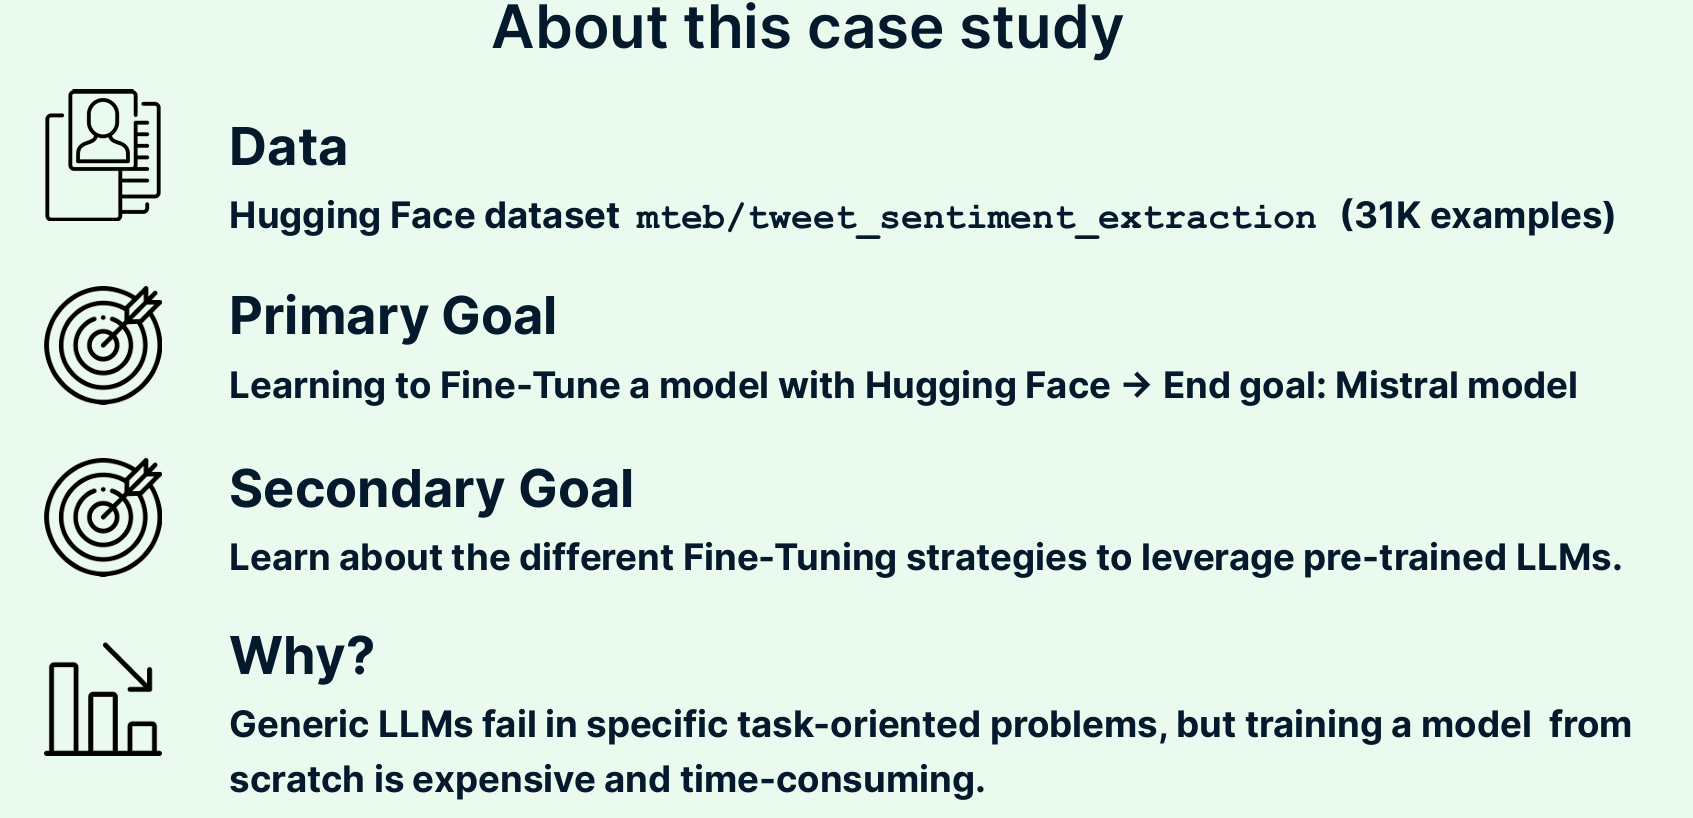

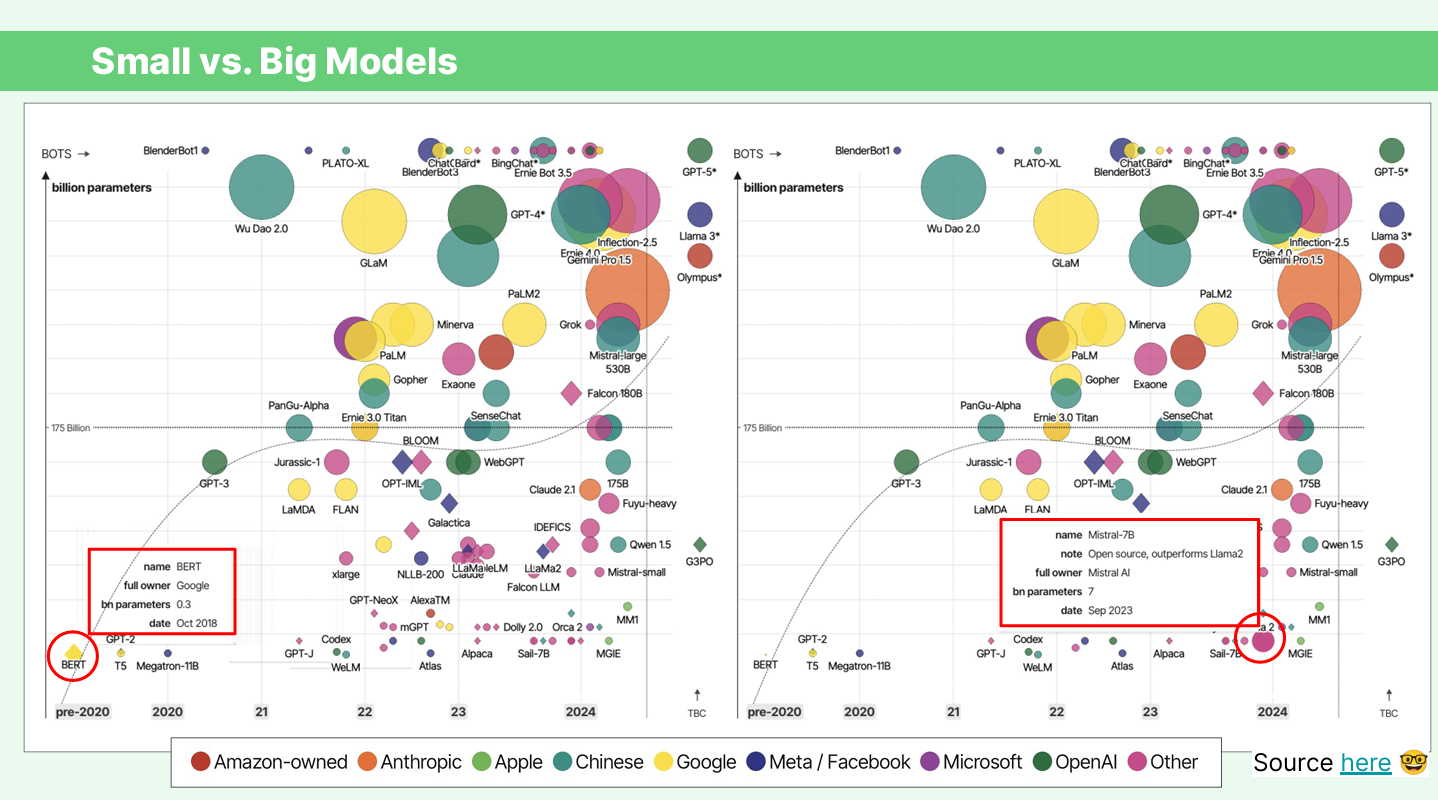

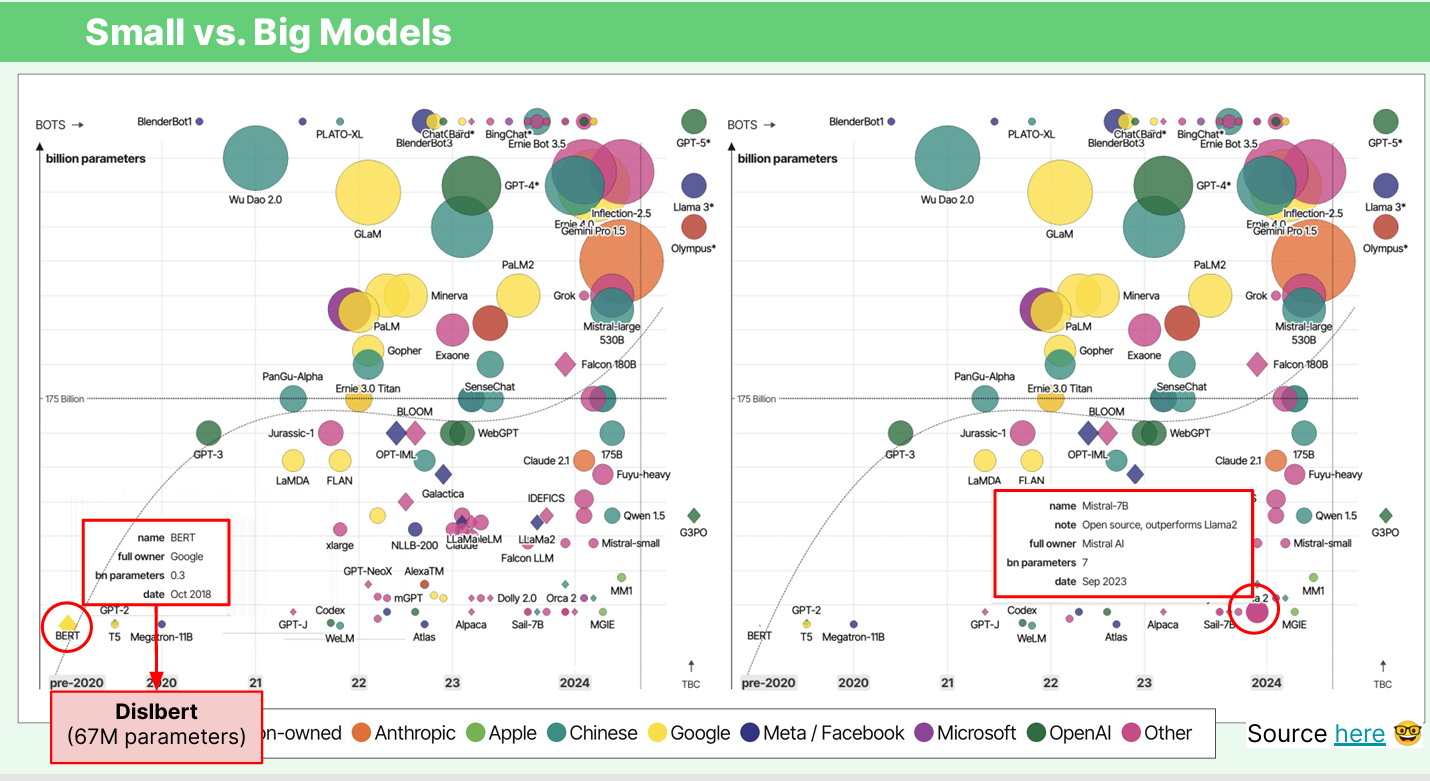

In [ ]:
import torch
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer # To import any model and tokenizer from the transformers library by just indicating its name, you can use the AutoModel and AutoTokenizer classes.
from transformers import BertForSequenceClassification, BertTokenizer, AdamW

# Define the model
model_name = 'distilbert/distilbert-base-uncased'
#model_name = 'google-bert/bert-base-uncased'

# Load both the model and the tokenizer
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3) -> Using the generic moules.
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3) # There's 3 possible labels: Positive, Negative and Neutral.

# Load the tokenize
#tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Function to predict the polarity of a given text using distilbert
def predict_polarity(text):

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model predictions
    outputs = model(**inputs)

    # Get the predicted class (0, 1 or 2)
    predictions = torch.argmax(outputs.logits, dim=1)

    # Map predicted class to polarity
    polarity_map = {0: "negative", 1: "neutral", 2: "positive"}
    polarity = polarity_map[predictions.item()]


    return polarity

# Example usage
print("*************************************\n The following sentence 'You are idiot!' is: ", predict_polarity("You are idiot!"))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.ou

*************************************
 The following sentence 'You are idiot!' is:  positive


In [ ]:
tweets_valid = ["MAD AS HELL! SOMEONE STOLE MY PINK & BLACK LEAPORD PRINT PUMPS I WANTED TO WEAR TODAY  BUT TO GOD BE THE GLORY, HE`LL BLESS ME ABUNDANTLY",
          "long day and i still have to mow the lawn", "omfg. one of the worst days ever!",
          "Never realized how good #Techmeme is until I actually read it (duh!) As an avid Tech Crunch reader, this is much better...",
          "yep  but I`m going better now"]

polarity_valid = ["Negative","Negative", "Negative", "Positive","Positive"]

tweets_model = []
for tweet in tweets_valid:
    tweets_model.append(predict_polarity(tweet))
tweets_model

['positive', 'positive', 'negative', 'neutral', 'negative']

# FEW-SHOT LEARNING
One example of fine-tuning would be the FEW-SHOT LEARNING.

In [ ]:
tweet_1 = "I hated Inside Out 2"
label_1 = "Negative"

tweet_2 = "I just received the offer of my dream job!"
label_2 = "Positive"

tweet = "I am feeling extremely sad today"

prompt = f"""
Consider the following examples of sentiment classifications:

"{tweet_1}" is classified as {label_1}.
"{tweet_2}" is classified as {label_2}.

Based on these examples, please classify the sentiment of the following tweet: "{tweet}"

"""

print(prompt)

print("The result is: ", predict_polarity(prompt))


Consider the following examples of sentiment classifications:

"I hated Inside Out 2" is classified as Negative.
"I just received the offer of my dream job!" is classified as Positive.

Based on these examples, please classify the sentiment of the following tweet: "I am feeling extremely sad today"


The result is:  positive


One natural question that comes to mind is:

*Can we do something to improve its performance?*

And the answer is **Yes!**

We can take advantage of fine-tuning by training our pre-trained distilbert model from the Hugging Face model with a dataset containing tweets and their corresponding sentiments so the performance improves.

Here's a basic example of fine-tuning a model for sequence classification:

# A Step-by-Step Guide to Fine-tuning a LLM
We already know that Fine-tuning is the process of taking a pre-trained model and updating its parameters by training on a dataset specific to your task. So, let’s exemplify this concept by fine-tuning a real model.

 ⚠️ **Disclaimer** In order to show live this fine-tuning, we will use the smallest model available ([disilbert with 67M parameters](https://huggingface.co/distilbert/distilbert-base-uncased)) and it will be trained with a hundred records, which, does not change much the accuracy of the model. It is to understand the process and how to fine-tune a real LLM.

 ## STEP 0 : Having Our Concrete Objective Clear 🎯

🎯 **OBJECTIVE**: Fine-tuning a pre-trained model to improve its performance detecting sentiments out of tweets.



 ## STEP 1 : Choose a pre-trained model and a dataset
To fine-tune a model, we always need to have a base pre-trained model in mind.
In our case, we are going to use:
- **Model**: [Distilbert 67M](https://huggingface.co/distilbert/distilbert-base-uncased)
- **Dataset**: [Tweet Sentiment Extraction](https://huggingface.co/datasets/mteb/tweet_sentiment_extraction) (It contains tweets and their corresponding sentiment positive, negative or neutral)

It is important to notice that we could use any other dataset, like extracted from kaggle, any online resource, or any local file we have.

In [ ]:
model_name = 'distilbert/distilbert-base-uncased'
dataset_name = "mteb/tweet_sentiment_extraction"

 ## STEP 2 : Load the dataset
We can use the `datasets` library from `hugging-face` to load our data.


The [Hugging Face Datasets](https://huggingface.co/datasets) library provides a vast collection of ready-to-use NLP datasets, making it easy to download, preprocess, and integrate data for various machine learning tasks. It seamlessly integrates with the `Transformers` library, allowing efficient use of pre-trained models. This library is designed to be user-friendly, supporting both beginners and experienced developers in their AI and NLP projects.



In [ ]:
from datasets import load_dataset

dataset = load_dataset(dataset_name)

# The dataset contains one table for training and one table for testing.
print(dataset)

# We can check the final dataframe.
df = pd.DataFrame(dataset["train"])
df.head(5)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})


,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative


 ## STEP 3 : Load the tokenizer
Large Language Models (LLMs) work with tokens, which are the building blocks of the text they process.

A tokenizer converts the input string into these tokens, enabling the model to understand and work with the input text effectively. Without a tokenizer, the model cannot interpret the raw text data.

We can obtain it directly from the `transformers` library of HuggingFace.

- **Padding:** All sequences are padded to the maximum length specified (default max_length parameter of the tokenizer if not explicitly set).
- **Truncation:** All sequences longer than the specified maximum length are truncated to ensure they fit within the maximum length.

In [ ]:
from transformers import BertTokenizer

# Load the tokenize
#tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


## STEP 4: Tokenize the dataset
Tokenizing the dataset when fine-tuning a model is crucial because **it converts the raw text into a format that the model can understand and process.**
This step ensures that the text data is compatible with the model's architecture and allows the model to learn from the input effectively.

To tokenize your dataset in one step, use the `Datasets` map method to apply a preprocessing function over the entire dataset.

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

import pandas as pd

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

df = pd.DataFrame(small_eval_dataset)
df

,id,text,label,label_text,input_ids,token_type_ids,attention_mask
0,0435d42f80,MAD AS HELL! SOMEONE STOLE MY PINK & BLACK LEA...,0,negative,"[101, 5506, 2004, 3109, 999, 2619, 10312, 2026...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2fac1b845b,whatever do you mean?,1,neutral,"[101, 3649, 2079, 2017, 2812, 1029, 102, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,7d59117a75,putting 3 new consultants to work this week. i...,2,positive,"[101, 5128, 1017, 2047, 22283, 2000, 2147, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,dad3160e52,long day and i still have to mow the lawn,0,negative,"[101, 2146, 2154, 1998, 1045, 2145, 2031, 2000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
4,da62e66fac,omfg. one of the worst days ever!,0,negative,"[101, 18168, 2546, 2290, 1012, 2028, 1997, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
...,...,...,...,...,...,...,...
95,59f6677324,The Heater blew up,0,negative,"[101, 1996, 3684, 2121, 8682, 2039, 102, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
96,ce4b5fe266,`s current goal is to lose 10 pounds by next t...,2,positive,"[101, 1036, 1055, 2783, 3125, 2003, 2000, 4558...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
97,9f345b18c5,"Totally agree, she wasn`t even as good as the...",1,neutral,"[101, 6135, 5993, 1010, 2016, 2347, 1036, 1056...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
98,9de7ee1962,if you weren`t 'picky' (=precise) i might not...,0,negative,"[101, 2065, 2017, 4694, 1036, 1056, 1005, 4060...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## STEP 5: Initialize our base model
Initializing the base model involves loading a pre-trained model that will serve as the starting point for fine-tuning. By initializing it, we leverage this prior knowledge and adapt it to our specific task, saving time and resources compared to training a model from scratch. This step sets up the model architecture and pre-loaded weights, making it ready for further training on our task-specific dataset.

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW

# Define the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Function to predict the polarity of a given text
def predict_polarity(text):
    # Tokenize the input text -> We tokenize any input text the model has.
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model predictions
    outputs = model(**inputs)

    # Get the predicted class (0 or 1)
    predictions = torch.argmax(outputs.logits, dim=1)

    # Map predicted class to polarity
    polarity_map = {0: "negative", 1: "neutral", 2: "positive"}
    polarity = polarity_map[predictions.item()]

    return polarity

# Example usage
print("*************************************\n The following sentence 'You are idiot!' is: ", predict_polarity("You are idiot!"))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.ou

*************************************
 The following sentence 'You are idiot!' is:  neutral


## STEP 6: Fine-tune using the Trainer Method

The `Trainer` module in Hugging Face's `Transformers` library is a high-level API designed to simplify the training and evaluation of models.
It abstracts much of the code required for training, providing a streamlined interface to set up, train, and evaluate models with minimal effort.
- **Training Loop Management:** Automates the entire training process, enabling users to focus on models and data.
- **Evaluation:** Incorporates evaluation during training to periodically assess model performance and adjust hyperparameters.
- **Distributed Training:** Facilitates training across multiple GPUs and TPUs, simplifying scalability.
- **Logging and Monitoring:** Offers integrated logging and monitoring with tools like TensorBoard and Weights & Biases.
- **Hyperparameter Management:** Eases the adjustment of hyperparameters via configuration objects for experimentation.
- **Customizable:** Allows for method overrides and functionality extensions for custom training and evaluation needs.

Evaluation Strategy:
**Purpose:** Defines the evaluation strategy to use during training.
- *"no"*: No evaluation is performed during training.
- *"steps"*: Evaluation is done every eval_steps.
- *"epoch"*: Evaluation is done at the end of each epoch.

In [ ]:
#from torch.utils.data import DataLoader

#train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
#valid_dataloader = DataLoader(small_eval_dataset, batch_size=8)

from transformers import Trainer, TrainingArguments
import torch

if torch.backends.mps.is_built():
    device = torch.device("mps")  # for mac use

training_args = TrainingArguments(
    output_dir='results', #  Specifies the directory where the model checkpoints and other outputs (such as logs) will be saved during and after training.
    evaluation_strategy="epoch", # Defines the evaluation strategy to use during training.
    learning_rate=2e-5, # Sets the initial learning rate for the optimizer. The learning rate controls how much to change the model in response to the estimated error each time the model weights are updated.
    per_device_train_batch_size=8, # Defines the batch size for training. This is the number of samples processed before the model is updated.
    per_device_eval_batch_size=8, # Defines the batch size for evaluation. This is the number of samples processed during evaluation.
    num_train_epochs=1, # Sets the number of epochs to train the model. An epoch is one complete pass through the entire training dataset.
    weight_decay=0.01, # Applies weight decay (L2 regularization) to the optimizer. This helps prevent overfitting by adding a penalty for large weights.
    no_cuda=True #  Training will be done on the CPU even if a GPU is available.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
)

trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1376: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.091412


TrainOutput(global_step=13, training_loss=1.1595279253446138, metrics={'train_runtime': 253.2442, 'train_samples_per_second': 0.395, 'train_steps_per_second': 0.051, 'total_flos': 26311341772800.0, 'train_loss': 1.1595279253446138, 'epoch': 1.0})

## STEP 7: Save the model and use it
Our final step is save the fine-tuned model and use it to extract the sentiment of tweets.

In [ ]:
# Save the model and tokenizer
trainer.save_model("fine-tuned-model")
tokenizer.save_pretrained("fine-tuned-model")

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained("fine-tuned-model")
tokenizer = BertTokenizer.from_pretrained("fine-tuned-model")

# Function to predict the polarity of a given text
def predict_polarity(text):
    # Tokenize the input text -> We tokenize any input text the model has.
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model predictions
    outputs = model(**inputs)

    # Get the predicted class (0 or 1)
    predictions = torch.argmax(outputs.logits, dim=1)

    # Map predicted class to polarity
    polarity_map = {0: "negative", 1: "neutral", 2: "positive"}
    polarity = polarity_map[predictions.item()]

    return polarity

text = "nice clutch"
predict_polarity(text)

'neutral'

In [ ]:
tweets_valid = ["MAD AS HELL! SOMEONE STOLE MY PINK & BLACK LEAPORD PRINT PUMPS I WANTED TO WEAR TODAY  BUT TO GOD BE THE GLORY, HE`LL BLESS ME ABUNDANTLY",
          "long day and i still have to mow the lawn", "omfg. one of the worst days ever!",
          "Never realized how good #Techmeme is until I actually read it (duh!) As an avid Tech Crunch reader, this is much better...",
          "yep  but I`m going better now"]

polarity_valid = ["Negative","Negative", "Negative", "Positive","Positive"]

#tweets_valid = ["I love this!", "I hate this", "It's okay."]
#polarity_valid = ["Positive", "Negative","Neutral"]


In [ ]:
tweets_model = []
for tweet in tweets_valid:
    tweets_model.append(predict_polarity(tweet))
tweets_model

['negative', 'neutral', 'neutral', 'negative', 'neutral']

# **Resources**

* [An Introductory Guide to Fine-Tuning LLMs](https://www.datacamp.com/tutorial/fine-tuning-large-language-models)
* [The Best Strategies for Fine-Tuning Large Language Models](https://www.kdnuggets.com/the-best-strategies-for-fine-tuning-large-language-models)

* [Quantization for Large Language Models (LLMs): Reduce AI Model Sizes Efficiently](https://www.datacamp.com/tutorial/quantization-for-large-language-models)

* [5 Key Points to Unlock LLM Quantization](https://medium.com/databites/key-points-llm-quantization-chatgpt-artificial-intelligence-8201ffcb33d4)